<a href="https://colab.research.google.com/github/eunzzae/Study_DL/blob/main/231111_CNN_%EC%8B%A4%EC%8A%B5_%5BAI_Bootcamp_06%5DPytorch_2_0_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch 2.0

- 기존 버젼인 1.13보다 훨씬 더 Pythonic 해졌다.

- torch.compile의 발전으로 timm이나 Huggingface를 사용할 때 성능향상이 커졌다.

- GPU에서 병렬 연산 최적화를 통해서 큰 모델에서도 효율적으로 연산이 가능해졌다.


Reference : https://pytorch.org/blog/pytorch-2.0-release/

### CIFAR10 Classification

- pytorch 2.0을 이용하여, CIFAR10 이미지 분류 문제를 풀어봅니다.

1. CIFAR10 데이터를 불러오고, 기본적인 전처리를 수행합니다.

2. 학습을 수행할 모델을 정의합니다.

3. 학습에 사용할 loss function과 optimizer를 정의합니다.

4. 학습을 수행합니다.

5. 학습한 모델로 예측을 수행합니다.

In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from time import time
import os
from tqdm.auto import tqdm

# 파이토치 라이브러리와 필요한 모듈들을 불러옵니다.
import torch
import torchvision
from torchinfo import summary

In [3]:
seed = 2023
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sat Nov 11 06:17:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
print(torch.__version__)
print(torchvision.__version__)
print(os.cpu_count())

2.1.0+cu118
0.16.0+cu118
2


### 1. 전처리 함수 정의하기

In [6]:
# 이미지 전처리에 필요한 transformation 함수를 정의 (pipeline 형태)
from torchvision.transforms import transforms

# for CIFAR10 (RGB channel)
transform = transforms.Compose([
    transforms.ToTensor(),         # numpy array를 torch.FloatTensor로 변환 & [0, 255] -> [0.0, 1.0]
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5)) # standard scaling [0.0, 1.0] - 0.5 ==> [-0.5, +0.5] / 0.5 ==> [-1.0, 1.0]
    # transforms.Nomalize(mean=(0.485, 0.456, 0.406), # ImageNet 데이터의 RGB channel별 mean, std.
    #                     std=(0.229, 0.224, 0.225))
])

# for ImageNet (RGB channel)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Nomalize(mean=(0.485, 0.456, 0.406), # ImageNet 데이터의 RGB channel별 mean, std.
#                         std=(0.229, 0.224, 0.225))
# ])

In [7]:
# torch에서 학습에 사용할 config variable들을 세팅합니다.
num_workers = 2
batch_size = 256
learning_rate = 1e-3 # ~ 0.000001(1e-6)
epochs = 10

In [8]:
# Data Load (Dataset, DataLoader)
trainset = torchvision.datasets.CIFAR10(root='./',
                                        train=True,
                                        download=True,
                                        transform=transform)
# iterator의 역할을 할 수 있음
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(dataset=testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers)

classes = ('airplane', 'automobile', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


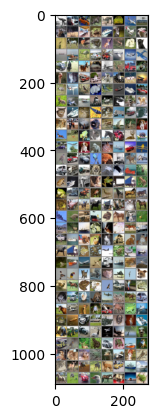

bird  truck automobile frog  airplane automobile airplane airplane cat   deer  airplane frog  ship  cat   bird  bird  bird  horse bird  frog  dog   deer  dog   dog   ship  ship  bird  automobile truck airplane airplane airplane automobile dog   horse automobile airplane frog  truck frog  bird  cat   truck cat   dog   truck horse airplane bird  airplane bird  cat   bird  ship  ship  ship  deer  airplane truck bird  horse cat   truck dog   cat   ship  frog  airplane dog   truck truck cat   cat   horse automobile automobile deer  ship  bird  dog   deer  deer  frog  cat   horse automobile deer  ship  automobile airplane dog   dog   deer  ship  automobile bird  bird  truck automobile bird  cat   truck deer  dog   automobile truck truck dog   airplane dog   ship  deer  frog  ship  bird  cat   frog  truck truck frog  frog  automobile deer  frog  bird  horse horse horse frog  automobile horse horse truck cat   cat   horse airplane deer  truck ship  frog  horse dog   deer  airplane deer  ship  

In [9]:
# show images

def imshow(img):
    img = img/2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# iterator를 이용해서 데이터를 불러오게 만듭니다. (batch processing을 위해서)
dataiter = iter(trainloader)  # trainloader를 iterator로 선언.
images, labels = next(dataiter) # next 함수는 iterator의 반복 수행함.

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
# shape을 확인합니다.
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


### 2. 학습 모델 정의


- 이미지 분류에 주로 쓰이는 모델은 CNN입니다.


- 처음에는 그냥 MLP(FCN)으로 구현을 하고, (나중에)Convolution 연산들을 추가해봅니다.


**모델 아키텍쳐**

- Conv => ReLU => Conv => ReLU => MaxPool => fc1 => fc2 => fc3(output)        (model1)
- Conv block(Conv-ReLU x 2) => maxPool => Conv block => MaxPool => fc(output) (model2)

In [11]:
import torch.nn as nn

# 모델 구현에 필요한 레이어들을 정의합니다. (외워야 함)


class CNN(nn.Module):
    def __init__(self):
      # X = (N - F) / S + 1
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6, # number of filters
                               kernel_size=3,
                               stride=1,
                               padding=0) # (3, 32, 32) => (6, 30, 30)
        self.conv2 = nn.Conv2d(6, 12, 3)  # (6, 30, 30) => (12, 28, 28)
        self.maxpool = nn.MaxPool2d(kernel_size=2,
                                    stride=2) # (12, 28, 28) => (12, 14, 14)
        self.fc1 = nn.Linear(in_features=12*14*14, # 2352
                             out_features=1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # feed-forward 연산을 구현합니다.
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = torch.flatten(x, 1) # (batch_size, 12, 14, 14) => (batch_size, 12*14*14) dim = 1인 이유
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [14]:
# (CNN)
# conv1 : ((3x3x3)+1) x 6
# conv2 : ((3x3x6)+1) x 12
# fc1 : ((12x14x14)+1) x 1024
# maxpool : 0

summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            168
├─Conv2d: 1-2                            660
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            2,409,472
├─Linear: 1-5                            131,200
├─Linear: 1-6                            1,290
├─ReLU: 1-7                              --
├─Softmax: 1-8                           --
Total params: 2,542,790
Trainable params: 2,542,790
Non-trainable params: 0

In [15]:
# show params
for x in model.parameters():
  print(x.shape) # real parameters

torch.Size([6, 3, 3, 3])
torch.Size([6])
torch.Size([12, 6, 3, 3])
torch.Size([12])
torch.Size([1024, 2352])
torch.Size([1024])
torch.Size([128, 1024])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


### 3. Optimizer와 Loss function 정의


- 학습에 가장 많이 사용하는 optimizer는 Adam입니다.


- 가장 기본이 되는 SGD(Stochastic Gradient Descent)와 Adam을 구현해서 비교해봅시다.

- multiclass classification에서 사용하는 loss function은 cross-entropy입니다.

In [16]:
from torch.optim._multi_tensor import AdamW
# import optimizers
import torch.optim as optim

optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### 4. 학습

- pytorch에서는 학습을 위해서 train 함수와 test 함수를 직접 구현해야합니다.

- 처음에는 직접 for문을 통해서 batch 단위 학습 코드를 구현해봅시다.

In [17]:
# ! pip install torchview

In [18]:
# from torchview import draw_graph

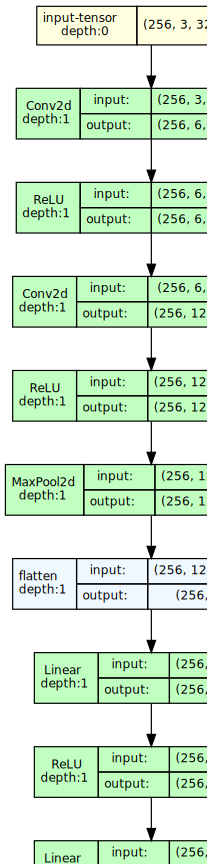

In [19]:
# Dynamic Computational Graph (Runtime) => forward 함수가 호출이 되어야 빌드됨.
# model_graph = draw_graph(model,input_size=(batch_size, 3, 32, 32))
# model_graph.visual_graph

In [20]:
images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [21]:
start = time()
## mini-batch-training

for epoch in tqdm(range(epochs)):
    n_correct = 0
    total_loss = 0.0
    for idx, data in enumerate(trainloader):
        optimizer.zero_grad() # gradient 초기화.

        #### feed forward ####
        images, labels = data[0].to(device), data[1].to(device) # GPU version
        outputs = model(images) # forward(x)
        loss = criterion(outputs, labels) # compute loss (tensor)
        n_correct = n_correct + (torch.max(model(images), dim=1)[1] == labels).sum() # batch당 맞은 개수
        total_loss += loss.item()

        #### back propagation ####
        loss.backward() # loss를 가지고 backprop
        optimizer.step() # SGD를 이용해서 weight update를 수행함.
    print(f'Epoch {epoch}, Train Accuracy : {n_correct/len(trainset):4f}\
                          | Train (average)Loss : {total_loss/len(trainloader):4f}')

end = time()

print("Training Done.")
print(f"Elasped Time : {end-start:.4f} secs.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Train Accuracy : 0.325320                          | Train (average)Loss : 2.128816
Epoch 1, Train Accuracy : 0.452120                          | Train (average)Loss : 2.006916
Epoch 2, Train Accuracy : 0.501120                          | Train (average)Loss : 1.957540
Epoch 3, Train Accuracy : 0.538980                          | Train (average)Loss : 1.920949
Epoch 4, Train Accuracy : 0.569880                          | Train (average)Loss : 1.890937
Epoch 5, Train Accuracy : 0.600180                          | Train (average)Loss : 1.862618
Epoch 6, Train Accuracy : 0.620880                          | Train (average)Loss : 1.841213
Epoch 7, Train Accuracy : 0.652480                          | Train (average)Loss : 1.811327
Epoch 8, Train Accuracy : 0.675160                          | Train (average)Loss : 1.789254
Epoch 9, Train Accuracy : 0.703100                          | Train (average)Loss : 1.762094
Training Done.
Elasped Time : 149.8944 secs.


### 5. 학습한 모델로 예측

- 학습한 model을 가지고 test data를 예측합니다.

- 예측 성능을 높이는 것이 학습의 목표이기 때문에, 학습되는 상황과 비교하여 잘 나오는 것을 확인해야 합니다.


- 예측도 직접 구현하여 확인할 수 있습니다.

In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [23]:
# # 예측 연산은 출력된 결과값중에서 argmax를 찾는 방식으로 수행됩니다.
# outputs = model(images)
# preds = torch.max(outputs, dim=1)[1]
# (preds == labels).sum() / batch_size
# #outputs.shape # 4장의 데이터에 대해서 10개 숫자.

# # # or
# # print("Predicted: ", ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

In [24]:
# make prediction for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# weight update를 하지 않는 모드 (inference only)
with torch.no_grad(): # test time 때, local gradient를 따로 저장하지 않음. (속도, 메모리)
    n_correct = 0
    total_loss = 0.0

    for idx, data in enumerate(testloader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        preds = torch.max(outputs, dim=1)[1]
        n_correct += (preds == labels).sum()
        total_loss += loss.item()
    print(f'Test Accuracy : {n_correct/len(testset):4f} | Test (average) Loss : {total_loss/len(testloader):4f}')



# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Test Accuracy : 0.615600 | Test (average) Loss : 1.845277


In [25]:
sum([class_[1] for class_ in correct_pred.items()]) / 10000 * 100

0.0

### Go Further?

- GPU를 켜서 수행해봅시다.


- 사실 딥러닝을 할 때는 무조건 GPU를 사용합니다.


- pytorch에서 GPU를 사용하기 위해서는 device를 정의한 후, device에 연산에 필요한 모델, 데이터를 보내는 것으로 자동으로 GPU acceleration이 일어나게 만듭니다.


- **.to(device)** 로 해당 모델과 데이터를 GPU로 보낼 수 있습니다.

In [26]:
# cuda가 있다는건 nvidia GPU가 있는 session을 쓰고 있다는 뜻.
